**The goal is to check the distribution of both the original data and the syntheic data to see if there is any difference**

In [66]:
import os
import sys
import joblib
import warnings
import sdmetrics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ctgan import CTGAN
from sdmetrics.visualization import get_column_plot
from sdmetrics.reports.single_table import QualityReport
warnings.filterwarnings('ignore')
sys.path.append( '../util' )
import util as util

**1. Load the datasets**

In [3]:
DATASET_DIRECTORY = '../csvfiles/'

dict_7classes = {}
dict_7classes['DDoS-RSTFINFlood'] = 'DDoS'
dict_7classes['DDoS-PSHACK_Flood'] = 'DDoS'
dict_7classes['DDoS-SYN_Flood'] = 'DDoS'
dict_7classes['DDoS-UDP_Flood'] = 'DDoS'
dict_7classes['DDoS-TCP_Flood'] = 'DDoS'
dict_7classes['DDoS-ICMP_Flood'] = 'DDoS'
dict_7classes['DDoS-SynonymousIP_Flood'] = 'DDoS'
dict_7classes['DDoS-ACK_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-UDP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-ICMP_Fragmentation'] = 'DDoS'
dict_7classes['DDoS-SlowLoris'] = 'DDoS'
dict_7classes['DDoS-HTTP_Flood'] = 'DDoS'

dict_7classes['DoS-UDP_Flood'] = 'DoS'
dict_7classes['DoS-SYN_Flood'] = 'DoS'
dict_7classes['DoS-TCP_Flood'] = 'DoS'
dict_7classes['DoS-HTTP_Flood'] = 'DoS'


dict_7classes['Mirai-greeth_flood'] = 'Mirai'
dict_7classes['Mirai-greip_flood'] = 'Mirai'
dict_7classes['Mirai-udpplain'] = 'Mirai'

dict_7classes['Recon-PingSweep'] = 'Recon'
dict_7classes['Recon-OSScan'] = 'Recon'
dict_7classes['Recon-PortScan'] = 'Recon'
dict_7classes['VulnerabilityScan'] = 'Recon'
dict_7classes['Recon-HostDiscovery'] = 'Recon'

dict_7classes['DNS_Spoofing'] = 'Spoofing'
dict_7classes['MITM-ArpSpoofing'] = 'Spoofing'

dict_7classes['BenignTraffic'] = 'Benign'

dict_7classes['BrowserHijacking'] = 'Web'
dict_7classes['Backdoor_Malware'] = 'Web'
dict_7classes['XSS'] = 'Web'
dict_7classes['Uploading_Attack'] = 'Web'
dict_7classes['SqlInjection'] = 'Web'
dict_7classes['CommandInjection'] = 'Web'


dict_7classes['DictionaryBruteForce'] = 'BruteForce'

In [4]:
file_names = []
for file in os.listdir(DATASET_DIRECTORY):
        file_names.append(file)
    
original_dataset = util.read_dataset(file_names, None)

In [5]:
# For some reason I cannot get the encode_label from util to load
# So i reverted to the original way for doing this

original_df = pd.DataFrame(original_dataset)
original_df['label'] = original_df['label'].map(dict_7classes).astype('category')
original_df['label'].value_counts()

label
DDoS          33984560
DoS            8090738
Mirai          2634124
Benign         1098195
Spoofing        486504
Recon           354565
Web              24829
BruteForce       13064
Name: count, dtype: int64

In [6]:
original_df.shape

(46686579, 47)

**1.1 Generate load synthetic data**

In [7]:
ctgan_model = CTGAN.load('../generator_custom/medium_synthesizer.pkl')

In [8]:
synthetic_data = ctgan_model.sample(4000000)

In [9]:
discrete_columns = [util.y_column, 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 
                    'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']

encoders = {}
encoders_new = joblib.load('column_encoders.joblib')

for column in discrete_columns:
    if column in encoders_new:
        synthetic_data[column] = encoders_new[column].inverse_transform(synthetic_data[column])

In [10]:
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df['label'].value_counts()

label
DDoS          2477160
DoS            599831
Mirai          247188
Benign         207292
Recon          190517
Spoofing       144559
BruteForce     103203
Web             30250
Name: count, dtype: int64

In [11]:
synthetic_df.shape

(4000000, 47)

**2. Create a sample of equal amount from the original**

In [12]:
original_sample = original_df.sample(n = 4000000, replace = False, ignore_index = True)

In [13]:
original_sample.shape, synthetic_df.shape

((4000000, 47), (4000000, 47))

**3. Lets see if there is a discrepancy between the label counts**

In [14]:
original_sample['label'].value_counts()

label
DDoS          2911401
DoS            693517
Mirai          225705
Benign          94163
Spoofing        41640
Recon           30309
Web              2190
BruteForce       1075
Name: count, dtype: int64

In [15]:
synthetic_df['label'].value_counts()

label
DDoS          2477160
DoS            599831
Mirai          247188
Benign         207292
Recon          190517
Spoofing       144559
BruteForce     103203
Web             30250
Name: count, dtype: int64

In [16]:
original_data_labels = [x for x in original_sample['label']]
synthetic_data_labels = [x for x in synthetic_df['label']]
combined_labels = original_data_labels + synthetic_data_labels

combined_df = pd.DataFrame(combined_labels, columns = ['label'])

combined_df.loc[:len(combined_df) // 2, 'data_source'] = 'Original Data'
combined_df.loc[(len(combined_df) // 2) - 1:, 'data_source'] = 'Synthetic Data'
combined_df = combined_df.iloc[:-1]

combined_df


,label,data_source
0,DDoS,Original Data
1,DDoS,Original Data
2,Mirai,Original Data
3,DDoS,Original Data
4,DoS,Original Data
...,...,...
7999994,DDoS,Synthetic Data
7999995,DDoS,Synthetic Data
7999996,DoS,Synthetic Data
7999997,DDoS,Synthetic Data


Text(0.5, 1.0, 'Comparison of Label Counts for Sampled Original Dataset vs Synthetic Dataset')

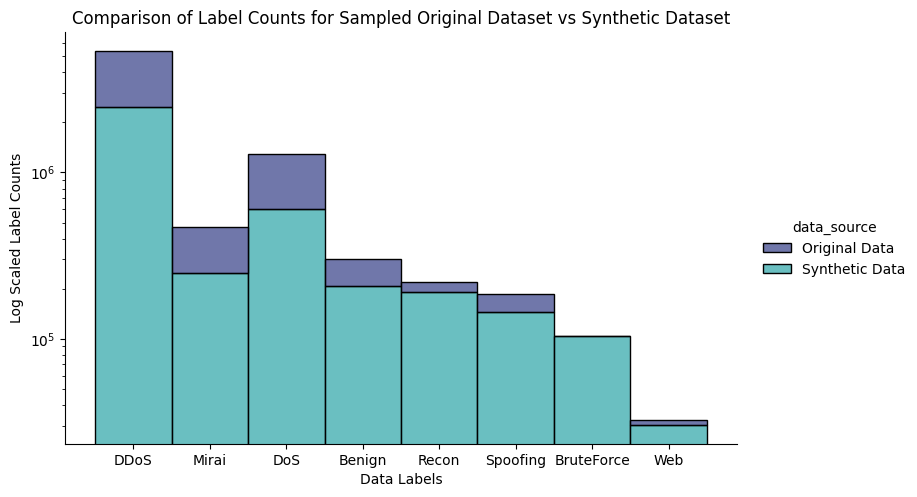

In [18]:
sns.color_palette(palette = 'deep6')
sns.displot(data = combined_df, x = 'label', hue = 'data_source', aspect = 1.5, multiple = 'stack', palette = 'mako')
plt.yscale('log')
plt.xlabel(xlabel = 'Data Labels')
plt.ylabel(ylabel = 'Log Scaled Label Counts')
plt.title(label = 'Comparison of Label Counts for Sampled Original Dataset vs Synthetic Dataset')

In [19]:
del combined_df, synthetic_data_labels, original_data_labels

In [37]:
synthetic_df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

In [52]:
synthetic_df

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,-0.020548,-0.099074,0.887062,-0.167973,0.057174,0.072034,-0.000842,-0.308079,-0.511166,-0.315431,...,-0.207489,-0.314580,-0.010631,0.001098,-0.345600,-0.208059,-0.094124,-0.413261,0.001167,DoS
1,-0.006266,-0.166075,-0.343389,-0.167610,-0.091072,-0.090670,-0.000755,-0.307828,1.956385,-0.315541,...,-0.207478,-0.289093,4.897042,4.882892,-0.303292,-0.207214,-0.094228,-0.413730,4.891167,Benign
2,-0.020176,-0.165964,-0.902363,-0.166647,-0.091270,-0.091011,-0.000743,-0.307712,-0.511201,-0.315435,...,-0.207221,-0.348968,-0.002940,0.001294,-0.475610,-0.207721,-0.093951,-0.413468,0.001137,DDoS
3,-0.020863,-0.165970,-0.343208,-0.167221,-0.090805,-0.090751,-0.000686,-0.308050,-0.511178,-0.315527,...,-0.207288,-0.283130,0.007793,0.001495,-0.331666,-0.207976,-0.094116,-0.413646,0.001156,DDoS
4,-0.020576,-0.166892,-0.902768,-0.168090,-0.090704,-0.090905,-0.000815,-0.307638,-0.511317,-0.315600,...,-0.208621,-0.339476,-0.003148,0.001254,-0.477389,-0.208222,-0.094689,-0.413905,0.001260,DDoS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.020257,-0.166433,-0.342966,-0.167801,-0.090169,-0.090358,-0.000866,-0.307993,1.956526,-0.315413,...,-0.207569,-0.297248,-0.006891,0.001263,-0.295301,-0.207821,-0.093707,-0.413864,0.000929,DDoS
3999996,-0.019251,-0.164556,0.885727,-0.167754,-0.090650,-0.090826,-0.000697,-0.307813,-0.511382,-0.315518,...,-0.208101,0.069068,-0.004438,0.001361,0.613336,-0.207649,-0.093934,-0.414638,0.001220,DoS
3999997,-0.020298,-0.165967,-0.342756,-0.168661,-0.089540,-0.089559,-0.000781,-0.307703,1.956263,-0.315360,...,-0.207341,-0.296746,-0.005968,0.001513,-0.293793,-0.207246,-0.093329,-0.413330,0.000886,DDoS
3999998,0.005643,-0.131456,-0.100458,4.015462,-0.091043,-0.090618,-0.000790,-0.307799,-0.511132,-0.315720,...,0.685973,0.004314,4.914316,4.884849,-0.066526,0.668895,-0.095027,3.881294,4.894707,Web


In [50]:
data_fig = get_column_plot(
    real_data = original_sample,
    synthetic_data = synthetic_df,
    column_name = 'label'
)

In [51]:
data_fig.write_html('plot.html')

**4. Get metadata from data**

In [76]:
original_sample['pk'] = range(0, len(original_sample))
original_sample.set_index('pk')

synthetic_df['pk'] = range(0, len(original_sample))
synthetic_df.set_index('pk')

original_sample

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,pk
0,-0.019346,-0.166105,-0.342706,-0.167679,-0.091005,-0.091005,-0.000754,-0.307859,1.955276,-0.315454,...,-0.292659,0.010742,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,0
1,-0.020227,-0.166154,-0.342706,-0.167679,-0.091016,-0.091016,-0.000754,3.248241,-0.511437,3.170039,...,-0.292659,0.009458,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,1
2,-0.020227,-0.166271,4.188047,-0.213330,-0.091024,-0.091024,-0.000754,-0.307859,-0.511437,-0.315454,...,1.855225,0.027229,0.001844,2.413413,-0.162372,-0.092191,-0.156384,0.001786,Mirai,2
3,-0.020227,-0.166271,-0.901644,-0.167679,-0.085243,-0.085243,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.342338,-0.003382,0.001844,-0.458554,-0.207678,-0.094913,-0.413893,0.001786,DDoS,3
4,-0.020227,-0.166154,-0.342706,-0.167679,-0.083544,-0.083544,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,-0.013576,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DoS,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999995,-0.003686,-0.166037,-0.342706,-0.167679,-0.091035,-0.091035,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,-0.013549,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DoS,3999995
3999996,-0.020227,-0.166154,-0.342706,-0.167679,-0.090888,-0.090888,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,-0.006237,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,3999996
3999997,-0.020227,-0.166154,-0.342706,-0.031436,-0.090989,-0.090989,-0.000754,-0.307859,-0.511437,-0.315454,...,-0.292659,0.007752,0.001844,-0.316334,-0.207678,-0.094913,-0.413893,0.001786,DDoS,3999997
3999998,-0.020221,-0.166149,-0.330410,-0.167679,-0.090922,-0.090922,-0.000754,-0.307859,1.955276,-0.315454,...,-0.291790,-0.005465,0.001844,-0.314772,-0.204416,-0.094905,0.015289,0.001786,DDoS,3999998


In [102]:
metadata = {
    'primary_key': 'pk',
    'columns': {column: {'sdtype': 'numerical', "compute_representation": "Float"} for column in original_sample.columns}
}

metadata['columns']['label']['sdtype'] = 'categorical'
metadata['columns']['pk']['sdtype'] = 'id'

metadata

{'primary_key': 'pk',
 'columns': {'flow_duration': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'Header_Length': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Protocol Type': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Duration': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Rate': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Srate': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'Drate': {'sdtype': 'numerical', 'compute_representation': 'Float'},
  'fin_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'syn_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'rst_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'psh_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'ack_flag_number': {'sdtype': 'numerical',
   'compute_representation': 'Float'},
  'ece_flag_number': 

In [103]:
report = QualityReport()

report.generate(
    real_data = original_sample,
    synthetic_data = synthetic_df,
    metadata = metadata,
    verbose = True 
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 48/48 [00:26<00:00,  1.81it/s]|
Column Shapes Score: 65.92%

(2/2) Evaluating Column Pair Trends: |██████████| 1128/1128 [09:25<00:00,  2.00it/s]|
Column Pair Trends Score: 94.72%

Overall Score (Average): 80.32%



In [104]:
report.get_score()

0.8031928877238592

In [125]:
report.get_details('Column Shapes')

,Column,Metric,Score
0,flow_duration,KSComplement,0.617217
1,Header_Length,KSComplement,0.658847
2,Protocol Type,KSComplement,0.738596
3,Duration,KSComplement,0.613582
4,Rate,KSComplement,0.751183
5,Srate,KSComplement,0.764605
6,Drate,KSComplement,0.235067
7,fin_flag_number,KSComplement,0.470925
8,syn_flag_number,KSComplement,0.232752
9,rst_flag_number,KSComplement,0.501954


In [107]:
fig = report.get_visualization('Column Shapes')
fig.write_html('column_shapes.html')

In [123]:
fig = report.get_visualization('Column Pair Trends')

fig.update_layout(width=6000, height=6000)
fig.update_xaxes(tickangle=90)

fig.update_layout(
    xaxis=dict(
        tickfont=dict(
            size=30  # Adjust the font size as needed
        )
    ),
    yaxis=dict(
        tickfont=dict(
            size=30  # Adjust the font size as needed
        )
    )
)

fig.write_html('column_pair_trends.html')